# Figure 2: Ridge and kernel ridge regression

This notebook generates figure 2 from 'Meta-Learning the Inductive Bias of Simple Neural Circuits', Dorrell et al. 2022.

This shows that we can meta-learn the inductive bias of simple ridge and kernel ridge regression

Very slight perturbations on this code were used to generate figures 9 and 10.

## Ridge regression

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
from geomloss import SamplesLoss  # See also ImagesLoss, VolumesLoss
from scipy import special

/Users/will/opt/anaconda3/envs/inductive_II/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# model parameters
input_size_gen = 2
hidden_size_gen = 150
output_size_gen = 1

K = 20
J = np.transpose(np.random.multivariate_normal(np.zeros(3),[[1,0,0],[0,1,0],[0,0,1]], (K)))
J = torch.from_numpy(J).float()

# Neural Network

layers = 2

class NeuralNet(nn.Module):
    def __init__(self,input_size_gen,hidden_size_gen, output_size_gen):
        super(NeuralNet,self).__init__()
        self.linear1 = nn.Linear(input_size_gen,hidden_size_gen, bias = True)
        self.linearh = nn.Linear(hidden_size_gen,hidden_size_gen, bias = True)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(hidden_size_gen,output_size_gen, bias = True)

    def forward(self, x):
        out = self.linear1(x)
        for i in range(layers-1):
            out = self.relu(out)
            out = self.linearh(out)
        #out = self.relu(out)
        out = self.relu(out)
        out = self.linear2(out)
        out = torch.cos(out)
        return out

In [3]:
# sampling data from Gaussian noise
def new_data(N):
  x = torch.zeros([N,2])
  for i in range(N):
	  theta = random.uniform(0,2*np.pi)
	  r = random.uniform(0,1)
	  x[i,0] = np.sqrt(r)*np.cos(theta)
	  x[i,1] = np.sqrt(r)*np.sin(theta)
  return x

def new_data_sq(N):
  x = 2*torch.rand([N,2])-1
  return x

# plots to see whether the function is learning 
def plot_linear_sparse(x, z_linear1, z_linear2, z_sparse1, z_sparse2):
  # Plot the loss and the classifications
  plt.figure(figsize = (15,8))

  plt.subplot(2,2,1)
  plt.scatter(x[:,0], x[:,1], c = z_linear1)
  plt.colorbar()
  plt.clim(-1,1) 
  plt.title('Linear regression 1')

  # Plot the two classifications
  plt.subplot(2,2,2)
  plt.scatter(x[:,0], x[:,1], c = z_linear2)
  plt.colorbar()
  plt.clim(-1,1) 
  plt.title('Linear regression 2')

  plt.subplot(2,2,3)
  plt.scatter(x[:,0], x[:,1], c = z_sparse1)
  plt.colorbar()
  #plt.clim(-1,1) 
  plt.title('Sparse linear regression 1')
  
  plt.subplot(2,2,4)
  plt.scatter(x[:,0], x[:,1], c = z_sparse2)
  plt.colorbar()
  #plt.clim(-1,1) 
  plt.title('Sparse linear regression 2')

def plot_stuff(x, fly_label, z_init, z, Losses):
  plt.figure(figsize = (8,8))

  plt.subplot(2,2,1)
  plt.plot(Losses)
  plt.title('Loss')

  plt.subplot(2,2,2)
  plt.scatter(x[:,0], x[:,1], c = z_init)
  plt.colorbar()
  #plt.clim(-1,1) 
  plt.title('Initial NN labelling')

  plt.subplot(2,2,3)
  plt.scatter(x[:,0], x[:,1], c = z)
  plt.colorbar()
  #plt.clim(-1,1) 
  plt.title('Final NN labelling')

  plt.subplot(2,2,4)
  plt.scatter(x[:,0], x[:,1], c = fly_label)
  plt.colorbar()
  #plt.clim(-1,1) 
  plt.title('Fly labelling')

In [4]:
def fly_linear(x, z):
  theta = torch.matmul(torch.inverse(torch.matmul(torch.transpose(x,0,1), x) + 0.001*torch.eye(2)),torch.matmul(torch.transpose(x,0,1), z))
  fly_label = torch.matmul(x, theta)
  return fly_label

def fly_linear_regression(x_tr, x_te, z_tr, z_te, distr):
  theta = torch.matmul(torch.inverse(torch.matmul(torch.transpose(x_tr,0,1), x_tr) + 0.001*torch.eye(2)),torch.matmul(torch.transpose(x_tr,0,1), z_tr))
  fly_label = torch.matmul(x_te, theta)
  loss = SamplesLoss(loss="sinkhorn", p=2, blur=.05)
  #print(f"Loss: {torch.mean((z-fly_label)**2)}")
  return torch.mean((z_te-fly_label)**2) + loss(distr, z_te) +loss(distr, z_tr)

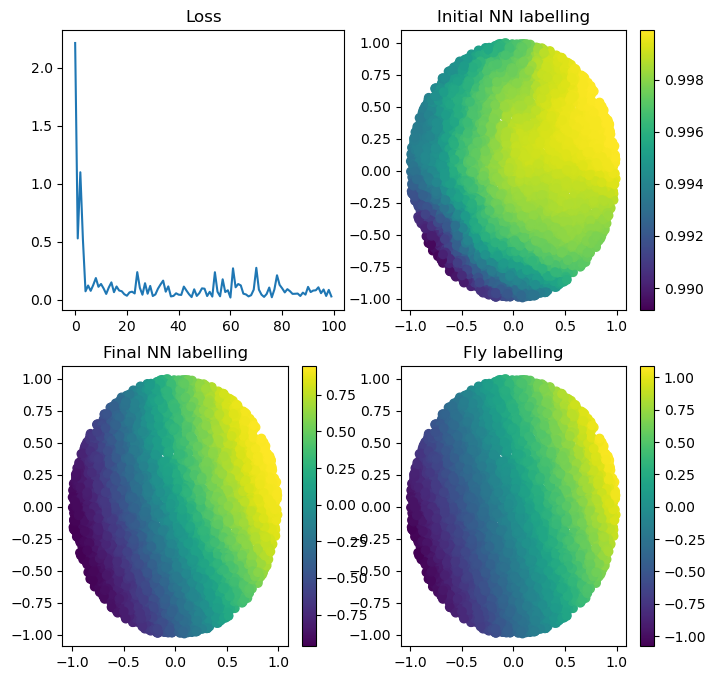

In [5]:
# Set up optimiser and loss
model_linear1 = NeuralNet(input_size_gen, hidden_size_gen, output_size_gen)
optimizer = optim.Adagrad(model_linear1.parameters(), lr=0.01)

# Parameter choices
M = 30 # Number of datapoints for each training step
T = 100 # Number of steps
M_plot = 5000 # number of points for plotting
Losses = np.zeros(T)

# Get initial labelling
x_plot = new_data(M_plot)
z_init = model_linear1(x_plot).detach().numpy()

# uniform distribution
distr = 2 * torch.rand(M//2, 1) - 1

# training loop
for step in range(T):
  optimizer.zero_grad()
  x_tr = new_data(M//5)
  x_te = new_data(M//5*4)
  z_tr = model_linear1(x_tr)
  z_te = model_linear1(x_te)
  loss = fly_linear_regression(x_tr, x_te, z_tr, z_te, distr)
  loss.backward(retain_graph=True)  
  optimizer.step()
  Losses[step] = loss.item()

z = model_linear1(x_plot).detach()
fly_label = fly_linear(x_plot, z)
fly_label_linear1 = fly_label.detach().numpy()

plot_stuff(x_plot, fly_label_linear1, z_init, z, Losses)


## Kernel regression

### In 2D:

In [10]:
K =20
J = np.transpose(np.random.multivariate_normal(np.zeros(2),[[1,0],[0,1]], (K)))
J = torch.from_numpy(J).float()

def fly_simple_kernel_learnt(x, J, z):
  y = torch.nn.functional.relu(torch.matmul(x,J))
  w = torch.matmul(torch.inverse(torch.matmul(torch.transpose(y,0,1), y) + 0.001*torch.eye(K)),torch.matmul(torch.transpose(y,0,1), z))
  #w = w/torch.norm(w, dim=0)[:,None]
  fly_label = torch.matmul(y, w) 
  return fly_label

def loss_simple_kernel_learnt(x_tr, x_te, z_tr, z_te, distr, J):
  y_tr = torch.nn.functional.relu(torch.matmul(x_tr,J))
  w = torch.matmul(torch.inverse(torch.matmul(torch.transpose(y_tr,0,1), y_tr) + 0.001*torch.eye(K)),torch.matmul(torch.transpose(y_tr,0,1), z_tr))
  #w = w/torch.norm(w, dim=0)[:,None]
  y_te = torch.nn.functional.relu(torch.matmul(x_te,J))
  fly_label = torch.matmul(y_te, w)

  loss = SamplesLoss(loss="sinkhorn", p=2, blur=.05) 

  return (loss(z_tr, distr) + loss(z_te, distr)) + torch.mean((z_te - fly_label)**2)

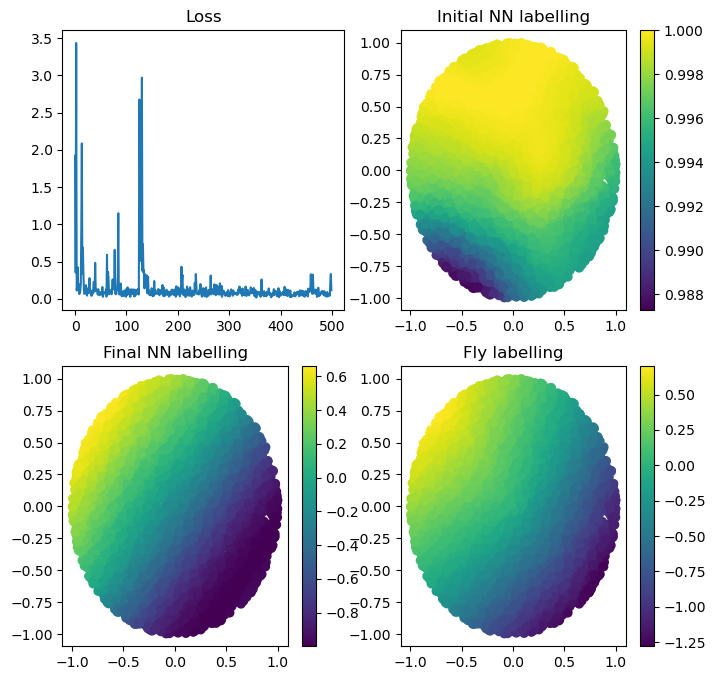

In [11]:
# Set up optimiser and loss
model = NeuralNet(input_size_gen, hidden_size_gen, output_size_gen)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)

# Parameter choices
M = 30 # Number of datapoints for each training step
T = 500 # Number of steps
M_plot = 5000 # number of points for plotting
Losses = np.zeros(T)

# Get initial labelling
x_plot = new_data(M_plot)
z_init = model(x_plot).detach().numpy()

# uniform distribution
distr = 2 * torch.rand(M//2, 1) - 1

# training loop
for step in range(T):
  optimizer.zero_grad()
  x_tr = new_data(M//5)
  z_tr = model(x_tr)
  x_te = new_data(M//5*4)
  z_te = model(x_te)
  loss = loss_simple_kernel_learnt(x_tr, x_te, z_tr, z_te, distr, J)
  loss.backward()  
  optimizer.step()
  Losses[step] = loss.item()

z = model(x_plot).detach()
fly_label = fly_simple_kernel_learnt(x_plot, J, z)
fly_label = fly_label.numpy()
z = model(x_plot).detach().numpy()

plot_stuff(x_plot, fly_label, z_init, z,  Losses)

### In 3D:

In [12]:
input_size_gen = 3
hidden_size_gen = 150
output_size_gen = 1

J = np.transpose(np.random.multivariate_normal(np.zeros(3),[[1,0,0],[0,1,0],[0,0,1]], (K)))
J = torch.from_numpy(J).float()

In [13]:
def new_data(N):
  x = torch.normal(0,1,[N,3])
  return x/torch.norm(x, dim = 1)[:,np.newaxis]

# projecting 3D plots onto 2D plane
def threeto2D(x):
  y = np.zeros([x.shape[0], 2])
  y[:,0] = np.arctan2(x[:,1],x[:,0])
  y[:,1] = np.arctan2(x[:,2],np.sqrt(np.power(x[:,0],2) + np.power(x[:,1],2)))
  return y

# plots to see whether the function is learning 
def plotty_dotty(x, Losses, y, fly_label, z_init, z):
  # Plot the loss and the classifications
  plt.figure(figsize = (8,8))
  
  # Plot losses
  plt.subplot(2,2,1)
  plt.plot(Losses)
  plt.title('Loss')

  # Plot the two classifications
  plt.subplot(2,2,2)
  plt.scatter(y[:,0], y[:,1], c = z_init)
  plt.colorbar()
  plt.clim(-1,1) 
  plt.title('Initial network labelling')

  plt.subplot(2,2,3)
  plt.scatter(y[:,0], y[:,1], c = fly_label)
  plt.colorbar()
  #plt.clim(-1,1) 
  plt.title('Fly labelling')
  
  plt.subplot(2,2,4)
  plt.scatter(y[:,0], y[:,1], c = z)
  plt.colorbar()
  #plt.clim(-1,1) 
  plt.title('Final network labelling')

In [15]:
def fly_simple_kernel_learnt(x, J, z):
  y = torch.nn.functional.relu(torch.matmul(x,J))
  w = torch.matmul(torch.inverse(torch.matmul(torch.transpose(y,0,1), y) + 0.001*torch.eye(K)),torch.matmul(torch.transpose(y,0,1), z))
  #w = w/torch.norm(w, dim=0)[:,None]
  fly_label = torch.matmul(y, w) 
  return fly_label

def loss_simple_kernel_learnt(x_tr, x_te, z_tr, z_te, distr, J):
    y_tr = torch.nn.functional.relu(torch.matmul(x_tr,J))
    w = torch.matmul(torch.inverse(torch.matmul(torch.transpose(y_tr,0,1), y_tr) + 0.001*torch.eye(K)),torch.matmul(torch.transpose(y_tr,0,1), z_tr))
    #w = w/torch.norm(w, dim=0)[:,None]
    y_te = torch.nn.functional.relu(torch.matmul(x_te,J))
    fly_label = torch.matmul(y_te, w)

    loss = SamplesLoss(loss="sinkhorn", p=2, blur=.05)
    loss_ent = loss(distr, torch.vstack([z_tr, z_te]))
    #loss_ent = MMD(distr, torch.vstack([z_tr, z_te]), 0.1*torch.ones([M,1]))
    #loss_ent = SmoothKNN(distr, torch.vstack([z_tr, z_te]), torch.ones([M,1]), 2)
    #loss_ent = Energy(distr, torch.vstack([z_tr, z_te]))

    return loss_ent + 10*torch.mean((z_te - fly_label)**2)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


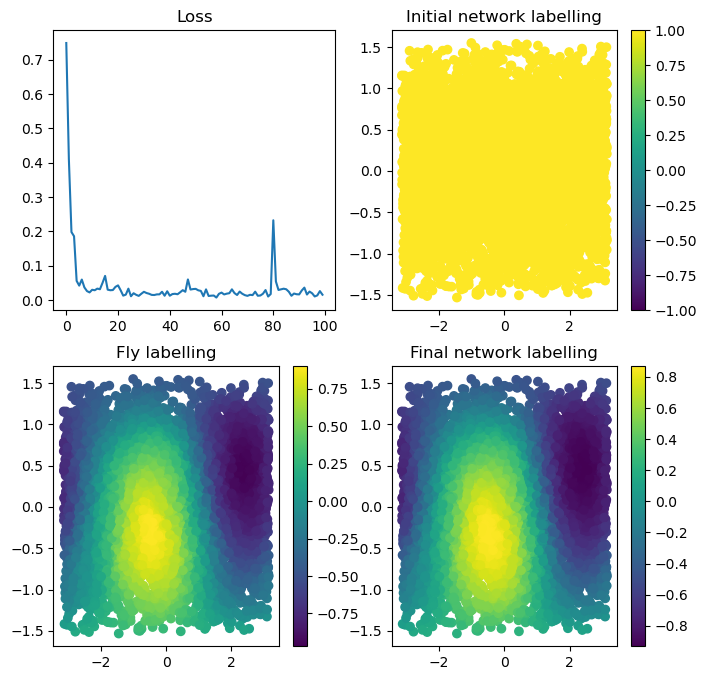

In [16]:
# Set up optimiser and loss
model = NeuralNet(input_size_gen, hidden_size_gen, output_size_gen)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)

# Parameter choices
M = 100 # Number of datapoints for each training step
T = 100 # Number of steps
M_plot = 5000 # number of points for plotting
Losses = np.zeros(T)

# Get initial labelling
x_plot = new_data(M_plot)
z_init = model(x_plot).detach().numpy()

# uniform distribution
distr = 2 * torch.rand(M, 1) - 1

# training loop
for step in range(T):
    if step % 10 == 0:
        print(f"{step/T}")
    optimizer.zero_grad()
    x_tr = new_data(M//5)
    z_tr = model(x_tr)
    x_te = new_data(M//5*4)
    z_te = model(x_te)
    loss = loss_simple_kernel_learnt(x_tr, x_te, z_tr, z_te, distr, J)
    loss.backward()  
    optimizer.step()
    Losses[step] = loss.item()

z = model(x_plot).detach()
fly_label = fly_simple_kernel_learnt(x_plot, J, z)
fly_label = fly_label.numpy()
z = model(x_plot).detach().numpy()
y = threeto2D(x_plot.detach().numpy())

plotty_dotty(x_plot, Losses, y, fly_label, z_init, z)

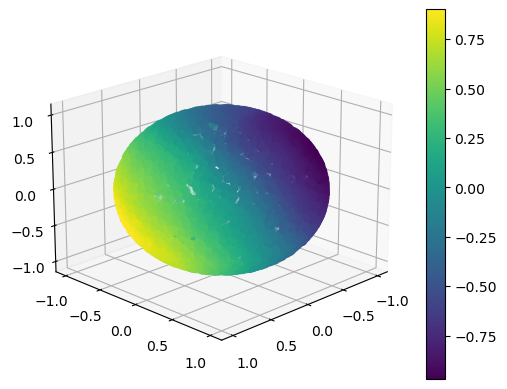

In [17]:
# Plot the 3D version of this
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(x_plot[:,0],x_plot[:,1], x_plot[:,2],c = fly_label, s = 30)
plt.colorbar(sc)
ax.view_init(elev=20, azim=45)

# Check, is this really a nice first order spherical harmonic? Dot onto all spherical harmonics

/Users/will/opt/anaconda3/envs/inductive_II/lib/python3.9/site-packages/matplotlib/axes/_axes.py:4186: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


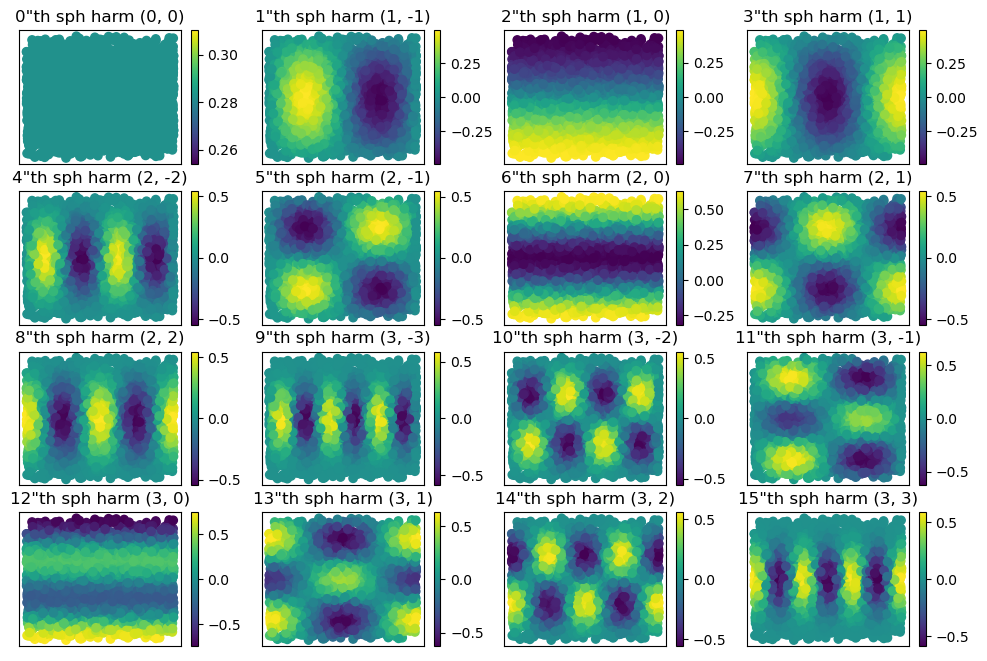

In [18]:
def threeto2Dsphharm(x):
  y = np.zeros([x.shape[0], 2])
  y[:,0] = np.arctan2(x[:,1],x[:,0])+torch.pi
  y[:,1] = np.arctan2(x[:,2],np.sqrt(np.power(x[:,0],2) + np.power(x[:,1],2)))+torch.pi/2
  return y

def convert_sph(m,n,y):
  if m < 0:
    sph = 2**(1/2)*(-1)**m*(special.sph_harm(abs(m), n, y[:,0], y[:,1]).imag)
  elif m == 0:
    sph = special.sph_harm(0, n, y[:,0], y[:,1])
  elif m > 0:
    sph = 2**(1/2)*(-1)**m*(special.sph_harm(m, n, y[:,0], y[:,1]).real)
  return sph

def sph_harm_plots(x):
  y = threeto2Dsphharm(x)
  #limit = torch.max(x)
  plt.figure(figsize = (12,8))
  ploty = 0
  for n in range(0,4):
    for m in range(-n, n+1, 1):
      sph = convert_sph(m,n,y)
      plt.subplot(4,4,ploty+1)
      plt.scatter(y[:,0], y[:,1], c = sph)
      plt.colorbar()
      plt.title(f'{ploty}"th sph harm {n,m}')
      frame1 = plt.gca()
      frame1.axes.get_xaxis().set_visible(False)
      frame1.axes.get_yaxis().set_visible(False)
      ploty+=1
    
sph_harm_plots(x_plot)

In [19]:
def sph_harm_func(x, n):
  '''
  This function produces spherical harmonics for the first n, where n is quantum number l.
  Output: sph_all: torch.tensor, size = [16,1000]
          16 - number of harmonic functions with different pairs n, m
          1000 - number of data points
  '''
  y = threeto2Dsphharm(x)
  plt.figure(figsize = (12,8))
  sph_all = []
  for i in range(n+1):
    for m in range(-i, i+1, 1):
      sph = convert_sph(m,i,y)
      sph_all.append(sph.real)
  sph_all = torch.tensor(sph_all)
  return sph_all
sph_all = sph_harm_func(x_plot, 3)
print(sph_all.shape)


torch.Size([16, 5000])


/var/folders/7s/qvjsjmdx0xz163b26_jzw9300000gn/T/ipykernel_96076/917172239.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_croot-udngs7fm/pytorch_1648016055234/work/torch/csrc/utils/tensor_new.cpp:201.)
  sph_all = torch.tensor(sph_all)


<Figure size 1200x800 with 0 Axes>

In [20]:
def dot_sph_func(sph_all, z):
  '''
  This function calculates the products of the model function with the spherical harmonics
  Output: val - proportion of each spherical harmonic function in the z function
          product - dot product of each spherical harmonics with z

  '''
  z = torch.flatten(z)
  product = torch.zeros((sph_all.shape[0],1))
  val = torch.zeros(product.shape)
  sph_all = sph_all.float()
  for i in range(sph_all.shape[0]):
    #product[i,:] = torch.arccos(torch.dot(sph_all[i,:],z)/(torch.sqrt((sph_all[i,:]**2).sum())*torch.sqrt((z**2).sum())))
    product[i,:] = torch.dot(sph_all[i,:],z)
  val = torch.absolute(product)/torch.sum(torch.absolute(product))
  return val, product

val, product = dot_sph_func(sph_all, torch.from_numpy(fly_label))
print(product)
print(val)


tensor([[ -74.9576],
        [ 402.6996],
        [ 279.4863],
        [-568.9264],
        [  22.3321],
        [ -37.2560],
        [ -61.8385],
        [ -10.7643],
        [  50.7665],
        [  -6.7646],
        [   2.3630],
        [   5.4846],
        [   4.0682],
        [ -23.0445],
        [  15.1093],
        [  12.9603]])
tensor([[0.0475],
        [0.2551],
        [0.1770],
        [0.3603],
        [0.0141],
        [0.0236],
        [0.0392],
        [0.0068],
        [0.0322],
        [0.0043],
        [0.0015],
        [0.0035],
        [0.0026],
        [0.0146],
        [0.0096],
        [0.0082]])


In [21]:
# Proportion on first order ones:
np.sqrt((product[1]**2 + product[2]**2 + product[3]**2)/np.linalg.norm(product)**2)

tensor([0.9869])